<a href="https://colab.research.google.com/github/Dimildizio/DArc_course/blob/main/ETL/ETL2sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [53]:
!pip install graphviz pydot

In [54]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
from IPython.display import Image

In [64]:
file_path = '99Bikers_Raw_data.xlsx'

df_transactions = pd.read_excel(file_path, sheet_name='Transactions')
df_customers_demographics = pd.read_excel(file_path, sheet_name='CustomerDemographic')
df_new_customers_list = pd.read_excel(file_path, sheet_name='NewCustomerList')
df_customer_addresses = pd.read_excel(file_path, sheet_name='CustomerAddress')

<ipython-input-64-31a145708b0a>:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_customers_demographics = pd.read_excel(file_path, sheet_name='CustomerDemographic')
<ipython-input-64-31a145708b0a>:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_new_customers_list = pd.read_excel(file_path, sheet_name='NewCustomerList')


## Create db

In [81]:
!touch mydb.db

In [87]:
conn = sqlite3.connect('mydb.db')

In [88]:
for x in (df_transactions, df_customers_demographics, df_new_customers_list, df_customer_addresses):
  print(x.columns)

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')
Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value'],
      dtype='object')
Index(['customer_id', 'address', 'postcode', 'state', 'country',
       'property_valuation'],
      dtype='object')


Drop default as a column with random stuff

In [89]:
if 'default' in df_customers_demographics.columns:
  df_customers_demographics.drop('default', axis=1, inplace=True)
for x in df_new_customers_list.columns:
  if 'Unnamed' in x:
    df_new_customers_list.drop(x, axis=1, inplace=True)

In [90]:
df_new_customers_list.columns

Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value'],
      dtype='object')

## Create stage tables

In [91]:
df_transactions.to_sql('stage_transactions', conn, if_exists='replace', index=False)#, dtype={'customer_id': 'TEXT'})
df_customers_demographics.to_sql('stage_customers_demographics', conn, if_exists='replace')#, index=False, dtype={'customer_id': 'TEXT'})
df_new_customers_list.to_sql('stage_new_customers_list', conn, if_exists='replace', index=False)# dtype={'customer_id': 'TEXT'})
df_customer_addresses.to_sql('stage_customer_addresses', conn, if_exists='replace', index=False)#, dtype={'customer_id': 'TEXT'})

3999

## Create DWH table queries

In [92]:
create_table_transactions = """
CREATE TABLE IF NOT EXISTS transactions AS
SELECT * FROM stage_transactions;
"""

create_table_customers_demographics = """
CREATE TABLE IF NOT EXISTS customers_demographics AS
SELECT * FROM stage_customers_demographics;
"""

create_table_new_customers_list = """
CREATE TABLE IF NOT EXISTS new_customers_list AS
SELECT * FROM stage_new_customers_list;
"""

create_table_customer_addresses = """
CREATE TABLE IF NOT EXISTS customer_addresses AS
SELECT * FROM stage_customer_addresses;
"""

In [93]:
table_names = ['transactions', 'customers_demographics', 'new_customers_list', 'customer_addresses']

### Create DWH tables

In [94]:
conn.execute(create_table_transactions)
conn.execute(create_table_customers_demographics)
conn.execute(create_table_new_customers_list)
conn.execute(create_table_customer_addresses)

In [95]:
engine = create_engine('sqlite:///mydb.db')

In [96]:
graph = pydot.Dot(graph_type='digraph')

In [97]:
table_schemas = {}
for table_name in table_names:
    query = f"PRAGMA table_info({table_name})"
    schema = pd.read_sql_query(query, conn)
    table_schemas[table_name] = schema

In [98]:
for table_name, schema in table_schemas.items():
    table_label = f"{table_name}\n{', '.join(schema['name'])}"
    node = pydot.Node(table_name, label=table_label, shape='box')
    graph.add_node(node)

In [99]:
image_path = 'erd.png'
graph.write_png(image_path)


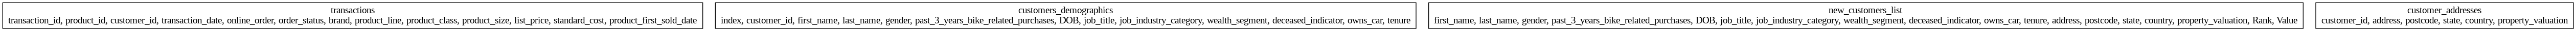

In [100]:
Image(image_path)

In [79]:
conn.close()

In [ ]:
schema = pd.read_sql_query(query, conn)